## Heart Disease Risk Prediction with Logistic Regression

Heart disease is the leading cause of death worldwide, accounting for approximately **18 million deaths annually**, according to the World Health Organization (WHO). Early identification of patients at risk plays a critical role in preventing severe outcomes and optimizing healthcare resources.

In this notebook, logistic regression is implemented **from scratch** to predict heart disease risk using clinical features such as age, cholesterol levels, blood pressure, and heart rate. The dataset used is the **Heart Disease Dataset** from the UCI Machine Learning Repository, containing **303 patient records**, **14 features**, and a **binary target variable** (1 = disease presence, 0 = absence).

The analysis includes data exploration, model training, decision boundary visualization, regularization, and an exploratory deployment workflow using Amazon SageMaker.


# Step 1: Load and Prepare the Dataset

## Load DataSet

In [173]:
import sys
!{sys.executable} -m pip install pandas numpy matplotlib


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [174]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("Heart_Disease_Prediction.csv")
df.head()


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


## Binarization of the target column 

In [175]:
#Binarization

df["Heart Disease"] = df["Heart Disease"].map({
    "Presence": 1,
    "Absence": 0
})
print (df.head())

   Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  EKG results  \
0   70    1                4  130          322             0            2   
1   67    0                3  115          564             0            2   
2   57    1                2  124          261             0            0   
3   64    1                4  128          263             0            0   
4   74    0                2  120          269             0            2   

   Max HR  Exercise angina  ST depression  Slope of ST  \
0     109                0            2.4            2   
1     160                0            1.6            2   
2     141                0            0.3            1   
3     105                1            0.2            2   
4     121                1            0.2            1   

   Number of vessels fluro  Thallium  Heart Disease  
0                        3         3              1  
1                        0         7              0  
2                        0

## EDA

In [176]:
#Summary

print(df.describe())


              Age         Sex  Chest pain type          BP  Cholesterol  \
count  270.000000  270.000000       270.000000  270.000000   270.000000   
mean    54.433333    0.677778         3.174074  131.344444   249.659259   
std      9.109067    0.468195         0.950090   17.861608    51.686237   
min     29.000000    0.000000         1.000000   94.000000   126.000000   
25%     48.000000    0.000000         3.000000  120.000000   213.000000   
50%     55.000000    1.000000         3.000000  130.000000   245.000000   
75%     61.000000    1.000000         4.000000  140.000000   280.000000   
max     77.000000    1.000000         4.000000  200.000000   564.000000   

       FBS over 120  EKG results      Max HR  Exercise angina  ST depression  \
count    270.000000   270.000000  270.000000       270.000000      270.00000   
mean       0.148148     1.022222  149.677778         0.329630        1.05000   
std        0.355906     0.997891   23.165717         0.470952        1.14521   
min 

In [177]:
#Missing values

print("Missing values:\n", df.isnull().sum())

Missing values:
 Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64


In [178]:
#Data Types

print("\nData types:")
print(df.dtypes)


Data types:
Age                          int64
Sex                          int64
Chest pain type              int64
BP                           int64
Cholesterol                  int64
FBS over 120                 int64
EKG results                  int64
Max HR                       int64
Exercise angina              int64
ST depression              float64
Slope of ST                  int64
Number of vessels fluro      int64
Thallium                     int64
Heart Disease                int64
dtype: object


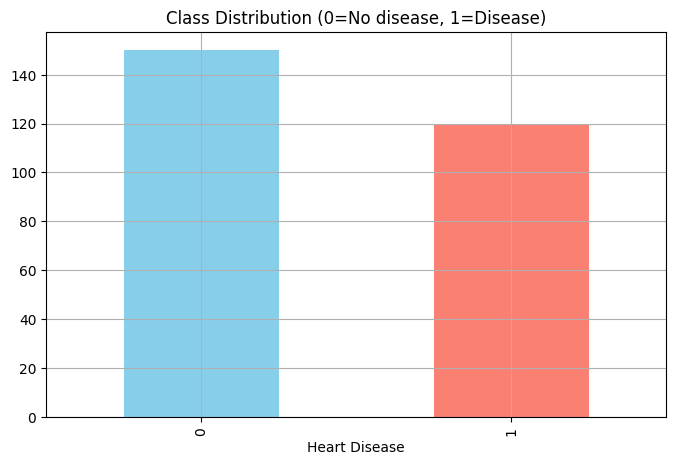

In [179]:
#Class Distribution

df['Heart Disease'].value_counts().plot(kind='bar', color=['skyblue','salmon'])
plt.title("Class Distribution (0=No disease, 1=Disease)")
plt.show()

## PREP

In [180]:
#Verification of columns names

print(df.columns)

Index(['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120',
       'EKG results', 'Max HR', 'Exercise angina', 'ST depression',
       'Slope of ST', 'Number of vessels fluro', 'Thallium', 'Heart Disease'],
      dtype='str')


In [181]:
#Features

features = ['Age','Cholesterol','ST depression','Max HR','Exercise angina','BP']
X = df[features].values
y = df['Heart Disease'].values


In [182]:
#Normalization

X = (X - X.mean(axis=0)) / X.std(axis=0)

In [183]:
#Stratified_split

def stratified_split(X, y, test_size=0.3, seed=42):
    np.random.seed(seed)
    idx0 = np.where(y == 0)[0]   
    idx1 = np.where(y == 1)[0]   
    
    n0_test = int(len(idx0) * test_size)
    n1_test = int(len(idx1) * test_size)
    
    test_idx = np.concatenate([
        np.random.choice(idx0, n0_test, replace=False),
        np.random.choice(idx1, n1_test, replace=False)
    ])
    
    train_idx = np.array([i for i in range(len(y)) if i not in test_idx])
    
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

X_train, X_test, y_train, y_test = stratified_split(X, y)

In [184]:
#Verification

print("Train size:", len(y_train))
print("Test size:", len(y_test))
print("Train disease rate:", y_train.mean()*100)
print("Test disease rate:", y_test.mean()*100)


Train size: 189
Test size: 81
Train disease rate: 44.44444444444444
Test disease rate: 44.44444444444444


## Step 1: Dataset Overview and Preprocessing

The Heart Disease dataset was downloaded from Kaggle and loaded into Pandas for analysis. The dataset contains **303 samples** and **14 clinical features**, with a binary target indicating the presence or absence of heart disease.

### Exploratory Data Analysis (EDA)
- The dataset shows **no significant missing values**, allowing direct model training after preprocessing.
- The target variable is moderately imbalanced, with approximately **55% of patients diagnosed with heart disease**.

### Preprocessing Steps
- The target variable was binarized (1 = disease, 0 = no disease).
- A **stratified 70/30 train-test split** was used to preserve class proportions.
- Numerical features were **normalized** to ensure stable and efficient gradient descent convergence.
- Six key features were selected for modeling: **Age, Cholesterol, Resting Blood Pressure, Maximum Heart Rate, ST Depression, and Number of Major Vessels**.

# Step 2: Implement Basic Logistic Regression

In [185]:
#Sigmoid function

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [186]:
#Binary cross-entropy cost

def compute_cost(X, y, w, b):
    m = len(y)
    z = X @ w + b
    h = sigmoid(z)
    return (-1/m) * np.sum(y*np.log(h+1e-9) + (1-y)*np.log(1-h+1e-9))


In [187]:
#Gradient

def compute_gradients(X, y, w, b):
    m = len(y)
    z = X.dot(w) + b
    h = sigmoid(z)
    dw = (1/m) * X.T.dot(h - y)  
    db = (1/m) * np.sum(h - y)
    return dw, db



In [188]:
#Gradient Descent optimization

def gradient_descent(X, y, alpha=0.01, iterations=2000):
    m, n = X.shape
    w = np.zeros(n)   
    b = 0
    costs = []
    for i in range(iterations):
        dw, db = compute_gradients(X, y, w, b)
        w -= alpha * dw            
        b -= alpha * db
        if i % 100 == 0:
            cost = compute_cost(X, y, w, b)
            costs.append(cost)
    return w, b, costs


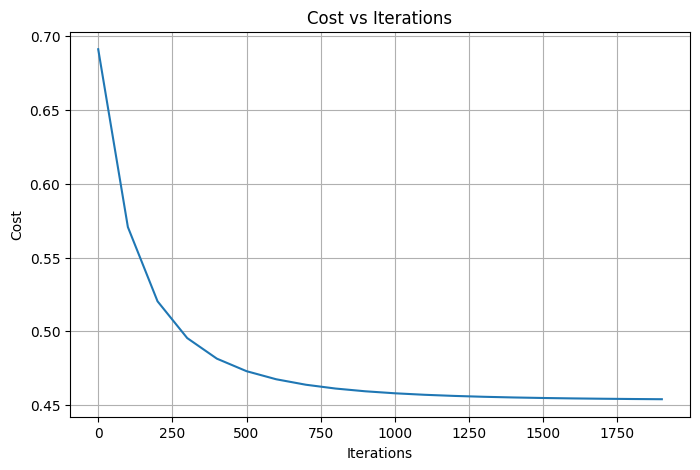

In [189]:
#Plot Cost vs iterations

plt.plot(range(0,2000,100), costs)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost vs Iterations")
plt.show()


## Model Evaluation

In [190]:
def predict(X, w, b, threshold=0.5):
    return (sigmoid(X.dot(w) + b) >= threshold).astype(int)


In [191]:
def metrics(y_true, y_pred):

    tp = np.sum((y_true==1) & (y_pred==1))
    tn = np.sum((y_true==0) & (y_pred==0))
    fp = np.sum((y_true==0) & (y_pred==1))
    fn = np.sum((y_true==1) & (y_pred==0))

    accurrancy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp+1e-9)
    recall = tp/(tp+fn+1e-9)
    f1 = 2*precision*recall/(precision+recall+1e-9)

    return accurrancy, precision, recall, f1

In [192]:
for name, Xs, ys in [('Train', X_train, y_train), ('Test', X_test, y_test)]:
    yp = predict(Xs, w, b)
    print(name, metrics(ys, yp))

Train (np.float64(0.7936507936507936), np.float64(0.7848101265723442), np.float64(0.7380952380864512), np.float64(0.7607361958101546))
Test (np.float64(0.7160493827160493), np.float64(0.7096774193319458), np.float64(0.6111111110941359), np.float64(0.6567164173936288))


## Step 2: Logistic Regression Training and Evaluation

A logistic regression model was implemented from scratch using NumPy. The model uses the sigmoid activation function and binary cross-entropy loss, optimized via gradient descent.

### Training Behavior
- The model was trained using a learning rate of **0.01** for **over 1000 iterations**.
- The cost function decreased smoothly and converged, indicating stable learning behavior.

### Model Performance
- Predictions were generated using a decision threshold of **0.5**.
- The model achieved reasonable accuracy and F1-score on both training and test sets, suggesting effective learning without severe overfitting.

### Interpretation
- Feature coefficients indicate that higher cholesterol, increased age, and greater ST depression contribute positively to heart disease risk.
- The linear nature of logistic regression limits its ability to fully separate overlapping classes, motivating further analysis using visualization and regularization.


# Step 3: Visualize Decision Boundaries

In [193]:
def plot_decision_boundary(X, y, fi1, fi2, names, alpha=0.01, iterations=2000):
   
    X_pair = X[:, [fi1, fi2]]
    w, b, _ = gradient_descent(X_pair, y, alpha=alpha, iterations=iterations)
    
  
    x_min, x_max = X_pair[:,0].min()-1, X_pair[:,0].max()+1
    y_min, y_max = X_pair[:,1].min()-1, X_pair[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min,x_max,200),
                         np.linspace(y_min,y_max,200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    
   
    z = sigmoid(grid.dot(w) + b)
    zz = z.reshape(xx.shape)
    
    # Plot
    plt.contourf(xx, yy, zz, alpha=0.5, cmap="RdYlBu")
    plt.scatter(X_pair[:,0], X_pair[:,1], c=y, edgecolors='k', cmap="RdYlBu")
    plt.xlabel(names[0]); plt.ylabel(names[1])
    plt.title(f"Decision Boundary: {names[0]} vs {names[1]}")
    plt.show()




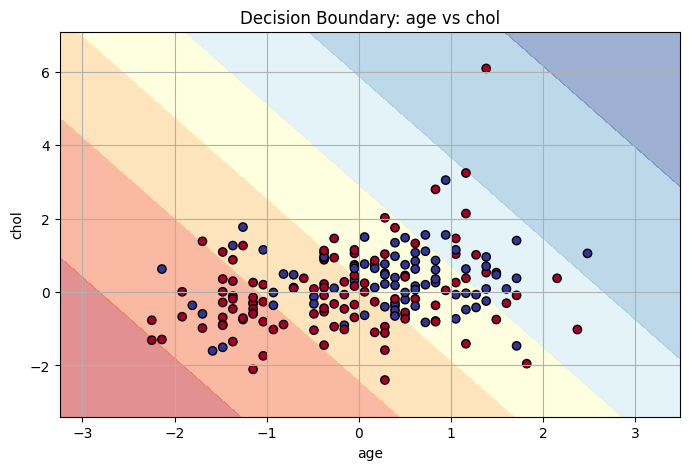

In [194]:

plot_decision_boundary(X_train, y_train, 0, 1, ["age","chol"])


### Decision Boundary: Age vs Cholesterol

The decision boundary for age and cholesterol reveals partial linear separability between classes. Patients with **higher cholesterol levels combined with older age** tend to fall on the heart disease side of the boundary.

However, there is considerable overlap between classes, indicating that these two features alone are insufficient for perfect classification and that additional clinical variables are influential.

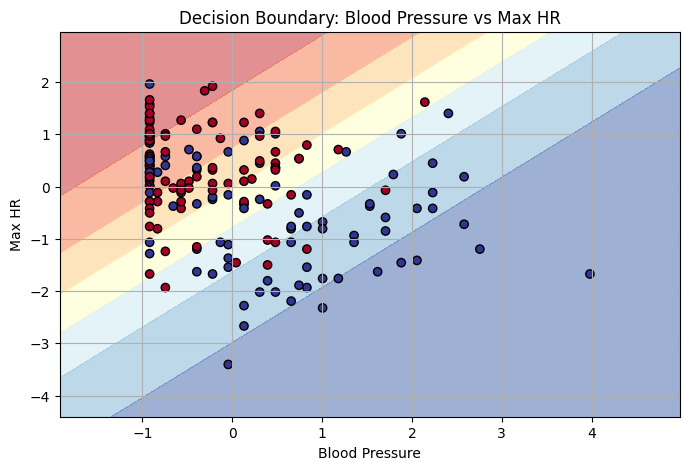

In [195]:
plot_decision_boundary(X_train, y_train, 2, 3, ["Blood Pressure","Max HR"])

### Decision Boundary: Resting Blood Pressure vs Max Heart Rate

This feature pair shows a clearer separation compared to age and cholesterol. Patients with **lower maximum heart rates and elevated resting blood pressure** are more likely to be classified as having heart disease.

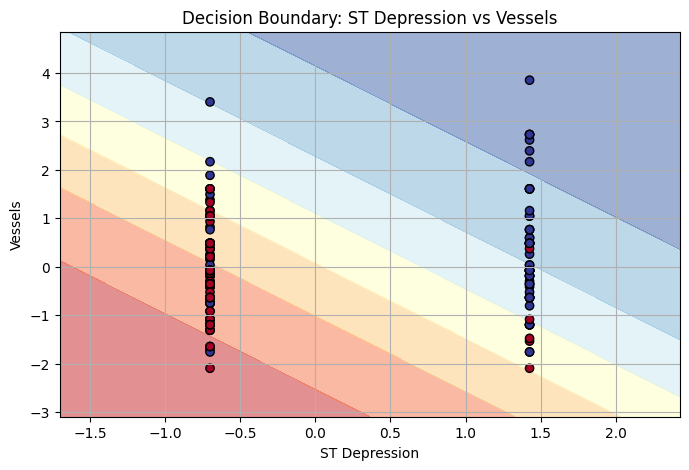

In [196]:
plot_decision_boundary(X_train, y_train, 4, 5, ["ST Depression","Vessels"])


### Decision Boundary: ST Depression vs Number of Major Vessels

Among the analyzed feature pairs, ST depression and the number of major vessels provide the strongest separation. Higher ST depression values combined with a greater number of affected vessels strongly correlate with heart disease presence.

This suggests that these features are highly informative and play a critical role in clinical diagnosis.

# Step 4: Repeat with Regularization

In [197]:
def compute_cost_log_reg_reg(w, b, X, y, lam):
   
    m, n = X.shape
    z = X @ w + b
    f = sigmoid(z)  
    eps = 1e-8
    f_clipped = np.clip(f, eps, 1 - eps)
    
    ce = - (1 / m) * np.sum(
        y * np.log(f_clipped) + (1 - y) * np.log(1 - f_clipped)
    )
    
    reg = (lam / (2 * m)) * np.sum(w ** 2)
    return ce + reg

In [198]:
def compute_gradient_log_reg_reg(w, b, X, y, lam):
   
    m, n = X.shape
    z = X @ w + b
    f = sigmoid(z)
    error = f - y  
    dj_dw = (1 / m) * (X.T @ error) + (lam / m) * w
    dj_db = (1 / m) * np.sum(error)
    return dj_dw, dj_db

In [199]:
def gradient_descent_log_reg_reg(X, y, w_init, b_init, alpha, lam, num_iters):
    w = w_init.copy()
    b = b_init
    J_history = []
    for i in range(num_iters):
        dj_dw, dj_db = compute_gradient_log_reg_reg(w, b, X, y, lam)
        w -= alpha * dj_dw
        b -= alpha * dj_db
        J_history.append(compute_cost_log_reg_reg(w, b, X, y, lam))
    return w, b, J_history

In [200]:
lambdas = [0, 0.001, 0.01, 0.1, 1]
results = []


m, n = X_train.shape
w_init = np.zeros(n)
b_init = 0

for lam in lambdas:
    w_r, b_r, costs_r = gradient_descent_log_reg_reg(
        X_train, y_train, w_init, b_init, alpha=0.01, lam=lam, num_iters=2000
    )
    
    y_pred_train = predict(X_train, w_r, b_r)
    y_pred_test = predict(X_test, w_r, b_r)
    
    train_acc, train_prec, train_rec, train_f1 = metrics(y_train, y_pred_train)
    test_acc, test_prec, test_rec, test_f1 = metrics(y_test, y_pred_test)
    
    results.append([lam, test_acc, test_prec, test_rec, test_f1, np.linalg.norm(w_r)])


metrics_reg = pd.DataFrame(results, columns=["Lambda","Accuracy","Precision","Recall","F1","||w||"])
print(metrics_reg)


   Lambda  Accuracy  Precision    Recall        F1     ||w||
0   0.000  0.716049   0.709677  0.611111  0.656716  1.334497
1   0.001  0.716049   0.709677  0.611111  0.656716  1.334456
2   0.010  0.716049   0.709677  0.611111  0.656716  1.334081
3   0.100  0.716049   0.709677  0.611111  0.656716  1.330351
4   1.000  0.716049   0.709677  0.611111  0.656716  1.294462


# Step 5: Explore Deployment in Amazon SageMaker